# Training Image Classification Model for Covid Test Results using ResNet50

### Install and Import Necessary Packages

In [1]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt

### Connect this notebook with google drive to get the data

In [3]:
# write the path of the image classification dataset on your google drive
dataset_dir = '/content/gdrive/MyDrive/classification_model_training/data/'

from google.colab import drive
drive.mount('/content/gdrive')

print('the following directories and files exist in dataset directory:')
!ls {dataset_dir}

Mounted at /content/gdrive
the following directories and files exist in dataset directory:
test  train


### Load Images as Tensorflow Dataset:

note: we can also use the Keras preprocessing utility (tf.keras.utils.iamge_dataset_from_directory) by dividing the train images into their respective classification directory 

i.e. we will have the following directories:
* train/positive: contain training images of postive results
* train/negative: contain training images of negative results
* train/empty: contain training images of empty results
* train/invalid: contain training images of invalid results

In [4]:
DESIRED_IMGWIDTH = 224 #Change back to 224
DESIRED_IMGHEIGHT = 224

In [5]:
train_data_dir = os.path.join(dataset_dir, 'train', '*/*.jp*g')
test_data_dir = os.path.join(dataset_dir, 'test', '*/*.jp*g')

In [6]:
# Legend for data labels
# 0 : positive
# 1 : negative
# 2 : empty
# 3 : invalid

#pay attention to the ordering because we will use this list for one hot encoding

class_names = ['positive', 'negative', 'empty', 'invalid']

In [7]:
train_ds = tf.data.Dataset.list_files(train_data_dir, shuffle=False)
test_ds = tf.data.Dataset.list_files(test_data_dir, shuffle=False)

In [8]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

361
79


#### Function that converts file path to an (img, label) pair

In [9]:
# image filename always contain the covid test result

def get_label(file_path):
  #convert path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  filename = parts[-1]
  test_result_class = tf.strings.split(filename, '_')[1] #2nd element is the image filename
  one_hot = test_result_class == class_names

  return one_hot #return the label in one hot encoding format

In [10]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [DESIRED_IMGHEIGHT, DESIRED_IMGWIDTH])

In [11]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#### Use Dataset.map to create a dataset of image, label pairs:

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [13]:
def configure_for_performance(ds, batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

batch_size = 32

train_ds = configure_for_performance(train_ds, batch_size)

In [26]:
test_ds= configure_for_performance(test_ds, batch_size)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

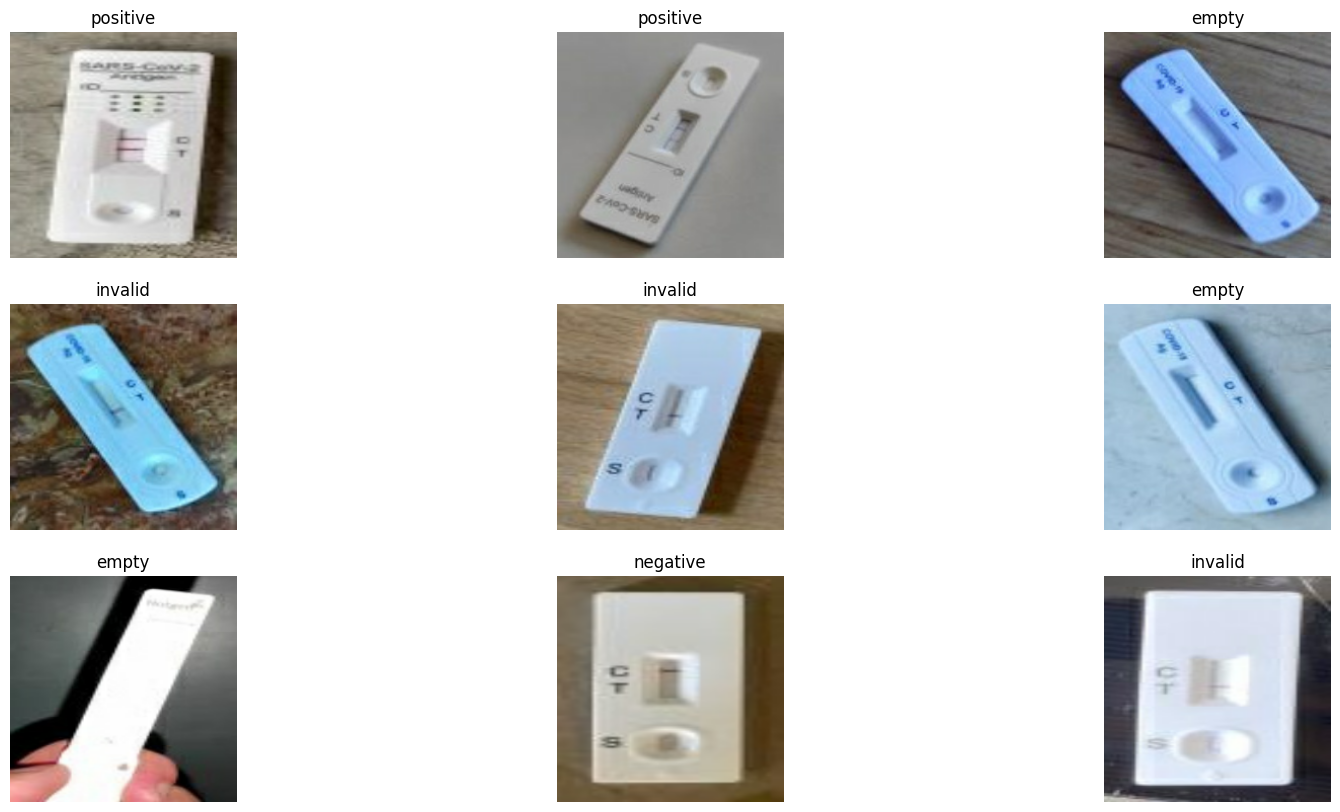

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(20, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  label = tf.argmax(label) #convert from one hot encoding to int encoding
  plt.title(class_names[label])
  plt.axis("off")

### Use Data Augmentation 


*   Horizontal Flipping
*   Random Rotation

For more info on augmentations, check here: [TensorFlow Data Augmentation Docu](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Example of the applied data augmentations on an image

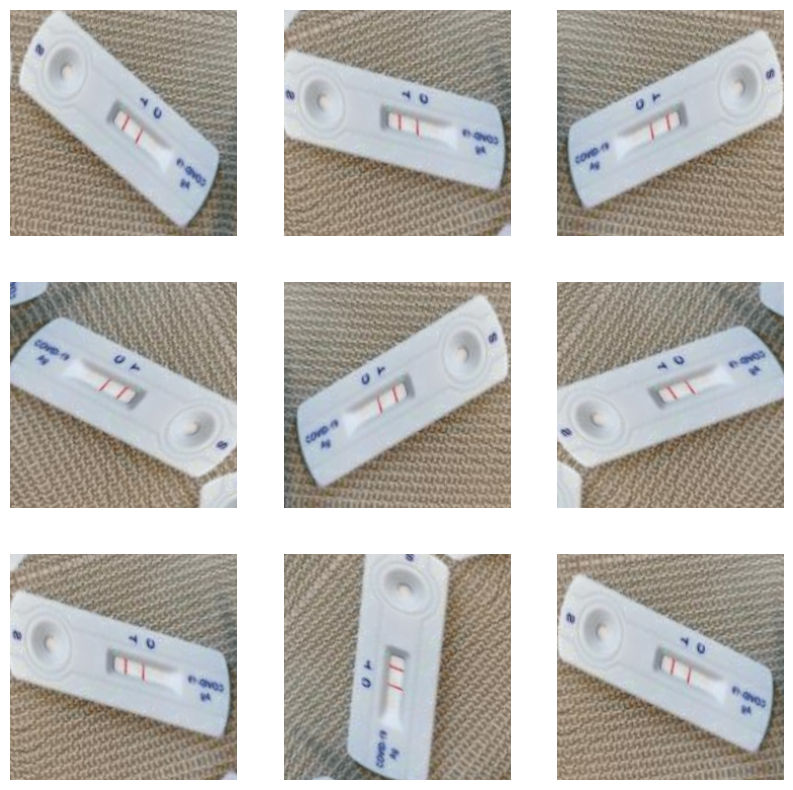

In [16]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Preprocess input for Resnet50

In [17]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [18]:
image_batch = preprocess_input(image_batch)

### Load Pretrained Model

In [19]:
num_classes = 4

In [20]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape = (224, 224, 3)
)

for layer in base_model.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
base_model.summary()

In [22]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten

In [23]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.layers[0].trainable = False

In [24]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, batch_size=64, epochs=40)

Epoch 1/40
12/12 [==============================] - 11s 39ms/step - loss: 12.4818 - accuracy: 0.3269
Epoch 2/40
12/12 [==============================] - 0s 18ms/step - loss: 3.7963 - accuracy: 0.7119
Epoch 3/40
12/12 [==============================] - 0s 18ms/step - loss: 0.9667 - accuracy: 0.8864
Epoch 4/40
12/12 [==============================] - 0s 18ms/step - loss: 0.2614 - accuracy: 0.9557
Epoch 5/40
12/12 [==============================] - 0s 18ms/step - loss: 0.2431 - accuracy: 0.9806
Epoch 6/40
12/12 [==============================] - 0s 18ms/step - loss: 0.1566 - accuracy: 0.9751
Epoch 7/40
12/12 [==============================] - 0s 18ms/step - loss: 0.0254 - accuracy: 0.9972
Epoch 8/40
12/12 [==============================] - 0s 18ms/step - loss: 6.4919e-04 - accuracy: 1.0000
Epoch 9/40
12/12 [==============================] - 0s 18ms/step - loss: 0.0050 - accuracy: 0.9972
Epoch 10/40
12/12 [==============================] - 0s 18ms/step - loss: 4.3509e-05 - accuracy: 1.0000

In [27]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 12s 148ms/step - loss: 12.8715 - accuracy: 0.3291


In [45]:
scores

[12.871509552001953, 0.3291139304637909]

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
 
ytrue=[]
image_batch, label_batch = next(iter(test_ds))
#print(label_batch)
"""
for  label in   label_batch:   
    for e in label:
      print(e.numpy().astype("uint8"))
      print(class_names[e.numpy().astype("uint8")])
      print(class_names[e])
      ytrue.append( class_names[e])
"""
#iterating over test_ds in batches
for  im, label in   test_ds: 
  print(label)
  for l in label:
    print(tf.argmax(l))
    ytrue.append(class_names[tf.argmax(l)])


In [ ]:
ytrue

3/3 [==============================] - 0s 16ms/step - loss: 12.8723 - accuracy: 0.3291
there were 17 correct predictions in 79 tests for an accuracy of   0.33 % 


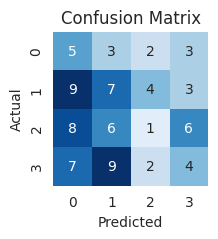

Classification Report:
----------------------
               precision    recall  f1-score   support

    positive       0.17      0.38      0.24        13
    negative       0.28      0.30      0.29        23
       empty       0.11      0.05      0.07        21
     invalid       0.25      0.18      0.21        22

    accuracy                           0.22        79
   macro avg       0.20      0.23      0.20        79
weighted avg       0.21      0.22      0.20        79



In [49]:
import numpy as np
ypred=[]
errors=0
count=0
preds=model.predict(test_ds, verbose=1) # predict on the test data
scores = model.evaluate(test_ds)
for i, p in enumerate(preds):
    count +=1
    index=tf.argmax(p) # get index of prediction with highest probability
    klass=class_names[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= scores[1]
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)
cm = confusion_matrix(ytrue, ypred )  
length=4      
fig_width= int(length * .5)
fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
#plt.xticks(np.arange(length)+.5, classes, rotation= 90)
#plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr) 



# Saving Model

In [ ]:
model_dir = '/content/gdrive/MyDrive/classification_model_training/jesica_model'
!mkdir -p model_dir

### In SavedModel Format

In [ ]:
savedmodel_path = os.path.join(model_dir, 'savedmodel')
model.save(savedmodel_path)

### In hdf5 Format

In [ ]:
#currently does not work --> Layer ModuleWrapper has arguments in `__init__` and therefore must override `get_config`.

#hdf5model_path = os.path.join(model_dir, 'model.h5')
#model.save(hdf5model_path)

NotImplementedError: ignored

# Convert to tensorflowjs

In [ ]:
!pip install tensorflowjs==3.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 3.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0


In [ ]:
converted_model = os.path.join(savedmodel_path, 'web_model')

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    {savedmodel_path} \
    {converted_model}

2023-03-20 00:06:08.484076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-20 00:06:08.484169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-20 00:06:08.484186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-20 00:06:11.263002: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environme